In [1]:
import numpy as np, itertools, os
import cupy as cp
import itertools
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from tqdm import tqdm
from scipy import stats

import astropy.units as u
import astropy.constants as cst

from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

In [2]:
from utils_telescope.simulate_visibility import compute_visibility, get_baselines
from utils_telescope.utils_sky import gaussian_2d, galactic_synch_fg_custom

from utils_telescope.mirto import MIRTO

In [23]:
print('\n------ Define Telescope ------')
# Loading the telescope and station layout coords:
telescope_layout = np.loadtxt('./utils_telescope/skalow_AA4_layout.txt') * u.m
station_layout = np.loadtxt('./utils_telescope/station_layout.txt') * u.m

N_ant = telescope_layout.shape[0]
N_B = int(N_ant*(N_ant-1)/2)

print(' number of stations:', N_ant)
print(' number of baselines:', N_B)

freq = 166. * u.MHz
lam = (cst.c / freq).to('m')
z = 1.42*u.GHz/freq - 1.
print(' frequency [MHz]:', freq)
print(' wavelength [m]:', lam)
print(' redshift:', z)

print('\n------ Define Observation ------')
# Declination
ra, dec = 0.* u.rad, -30. * u.deg
print(' (RA, Dec): (%.3f %s, %.3f %s)' %(ra.value, ra.unit, dec.value, dec.unit))

# integration time
int_time = (10.*u.s).to('h')
print(' Integration time :', int_time.to('s'))

# Radial angle, Hour angle window
h_angle = np.arange(-2, 2, int_time.value) * u.hourangle

time_steps = h_angle.size
print(' Number of time steps : ', time_steps)

t_obs = h_angle.max()-h_angle.min()
print(' Observation length :', t_obs)

print('\n------ Antenna Parameters ------')
D = np.linalg.norm(station_layout, axis=1).max()*2
print(' dish diameter [m]:', D)

theta_fwhm = (1.03 * lam / D) * u.rad
theta_0 = 0.6 * theta_fwhm
V_0 = (np.pi * theta_0**2 / 2).to('sr')
print(' theta_fwhm:', theta_fwhm)
print(' theta_0:', theta_0)
print(' V_0:', V_0)

print('\n------ Observational Quantities ------')
N_pix = 256
FoV = np.sqrt(V_0).to('rad')
print(' FoV:', FoV.to('deg'))

# define a 1D sky and get RA coordinate
thet = np.linspace(-FoV/2, FoV/2, N_pix).to('rad').value
dthet = np.diff(thet)[0] # rad
print(' dthet:', (dthet*u.rad).to('arcsec'))

# Create a grid of points (we ignore third dimension, i.e. n-axis)
l_coord, m_coord = np.meshgrid(thet, thet)
lmn_coord = np.dstack((l_coord, m_coord)).reshape(-1, 2)

# Create a beam pattern
beam_pattern = np.exp(-((l_coord**2 + m_coord**2) / theta_0.value**2))


------ Define Telescope ------
 number of stations: 512
 number of baselines: 130816
 frequency [MHz]: 166.0 MHz
 wavelength [m]: 1.8059786626506023 m
 redshift: 7.554216867469879

------ Define Observation ------
 (RA, Dec): (0.000 rad, -30.000 deg)
 Integration time : 10.0 s
 Number of time steps :  1440
 Observation length : 3.997222222222208 hourangle

------ Antenna Parameters ------
 dish diameter [m]: 38.06656275525806 m
 theta_fwhm: 0.048865930829890346 rad
 theta_0: 0.029319558497934207 rad
 V_0: 0.0013503138730938376 sr

------ Observational Quantities ------
 FoV: 2.105426074955234 deg
 dthet: 29.72366223466223 arcsec


In [41]:
print('\n------ Define Sky Model ------')
L_box = FoV.to('rad').value * (1+z)*cosmo.angular_diameter_distance(z)

# Get the sky model
#dT_jy = np.zeros((N_pix, N_pix))
#dT_jy[N_pix//2, N_pix//2] = 1.
#dT_jy = gaussian_2d(prefactor=1e-3, x=l_coord, y=m_coord, mean=np.array([0.005, -0.004]), cov=np.array([[(8e-1*u.arcsec).to('rad').value, 0], [0, (1e-1*u.arcsec).to('rad').value]]))
dT_jy = galactic_synch_fg_custom(z=[z], ncells=N_pix, boxsize=L_box.value, A150=513., beta_=2.34, rseed=918)

# correct the brightness temperature beacuse we are using images and not point sources
beam_sim = dthet**2 
#dT_jy *= beam_sim

# Get primary beam
solid_angl = (np.pi*theta_0**2/(4*np.log(2))).to('sr')

sigma = np.sqrt(8*np.log(2)) * theta_fwhm.value
beam_jy = gaussian_2d(prefactor=1, x=l_coord, y=m_coord, mean=np.array([0., 0.]), cov=np.array([[sigma, 0], [0, sigma]]))

print(' Boxsize:', L_box)
print(' Solid angle: %.3e %.s' %(solid_angl.value, solid_angl.unit))
print(' Sigma: %.3e' %(sigma))


------ Define Sky Model ------
 Boxsize: 330.573531325587 Mpc
 Solid angle: 9.740e-04 
 Sigma: 1.151e-01


In [27]:
obs = MIRTO(wavelength=lam.value, 
            layout=telescope_layout.value, 
            beam_pattern=beam_jy, 
            #beam_pattern=None, 
            lmn=lmn_coord, 
            RA=ra, Dec=dec, 
            I_sky=dT_jy, 
            flat_sky=False)

#uv_coord, uv_length = obs.get_baselines(max_norm=2000.)
uv_coord, uv_length = obs.get_baselines()

Calculate baselines: 100%|██████████| 130816/130816 [00:00<00:00, 690218.22it/s]


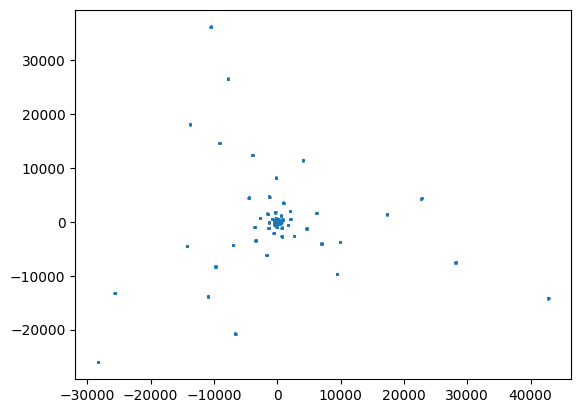

In [28]:
plt.scatter(obs.layout[:,0], obs.layout[:,1], s=1)

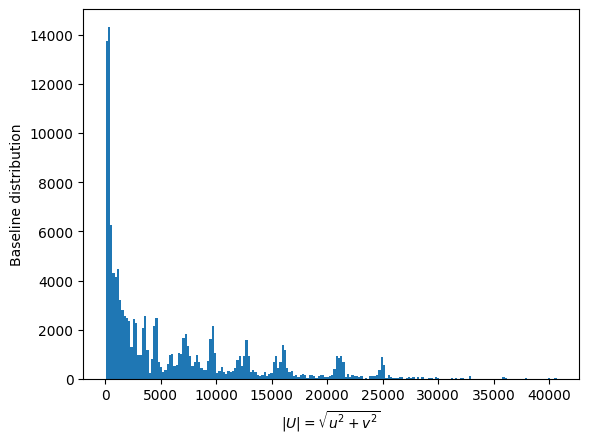

In [29]:
plt.hist(uv_length, bins=200);
plt.xlabel(r'$|U| = \sqrt{u^2 + v^2}$'), plt.ylabel('Baseline distribution')
plt.show()

In [30]:
uv_plane, uv_sampl, u_bin = obs.visibility_timesteps(h_angle=h_angle, 
                                                     uvw=uv_coord, 
                                                     chunk_size=1024, 
                                                     grid_vis=True)

u_vals = 0.5*(u_bin[1:]+u_bin[:-1])

Calculate visibility: 100%|█████████████████| 1440/1440 [01:23<00:00, 17.34it/s]


In [31]:
u_vals = 0.5*(u_bin[1:]+u_bin[:-1])

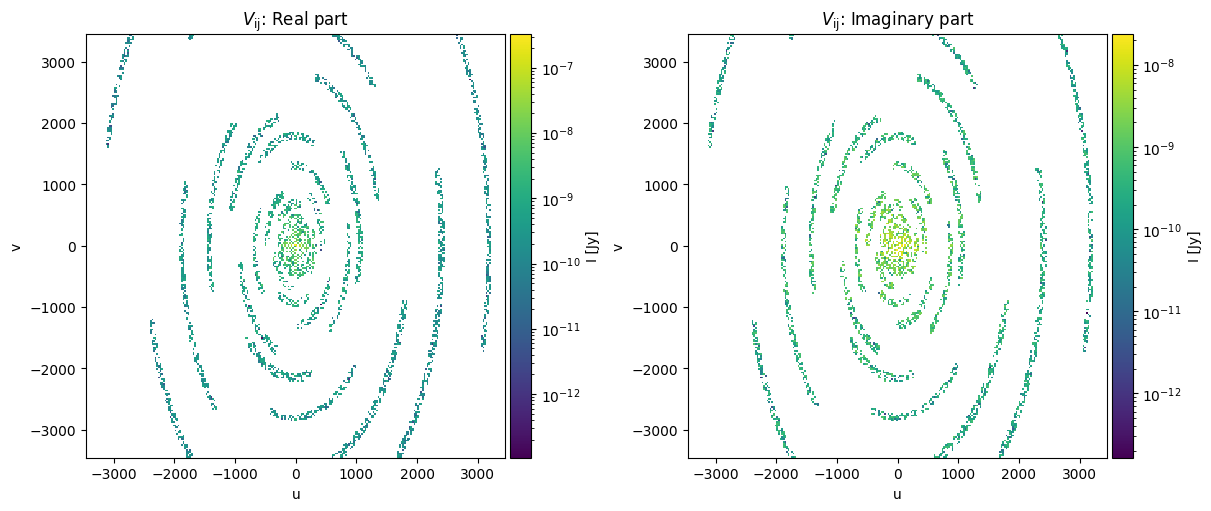

(None, None)

<Figure size 640x480 with 0 Axes>

In [34]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2, nrows=1, constrained_layout=True)
axs[0].set_title(r'$V_\mathrm{ij}$: Real part')
im = axs[0].pcolormesh(u_vals, u_vals, uv_plane.real, cmap='viridis', norm='log')
axs[0].set_xlabel(r'u'), axs[0].set_ylabel(r'v')
plt.colorbar(im, ax=axs[0], label='I [Jy]', pad=0.01)

axs[1].set_title(r'$V_\mathrm{ij}$: Imaginary part')
im = axs[1].pcolormesh(u_vals, u_vals, uv_plane.imag, cmap='viridis', norm='log')
axs[1].set_xlabel(r'u'), axs[1].set_ylabel(r'v')
plt.colorbar(im, ax=axs[1], label='I [Jy]', pad=0.01)
plt.show(), plt.clf()

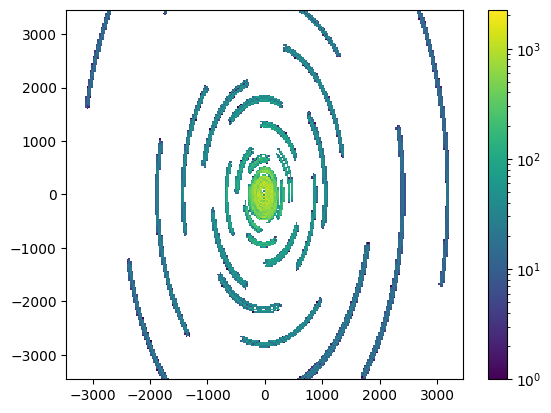

In [35]:
plt.pcolormesh(u_vals, u_vals, uv_sampl, norm='log')
plt.colorbar()

In [36]:
# inverse fourier transform gridded visibility
I_sky_reconstruct = np.fft.ifft2(uv_plane)
I_sky_reconstruct = np.fft.fftshift(np.abs(I_sky_reconstruct))

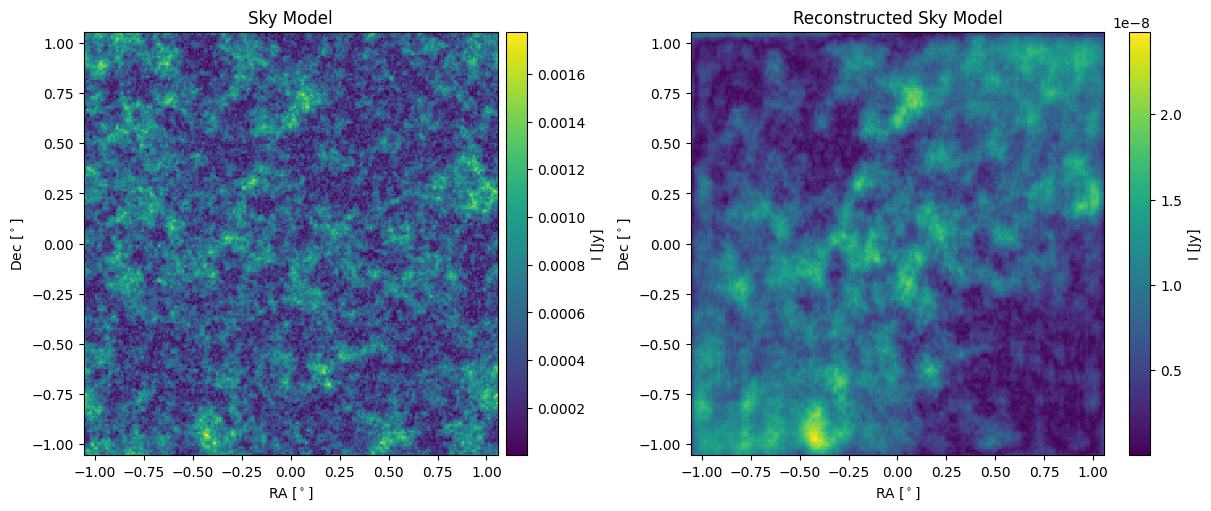

(None, None)

<Figure size 640x480 with 0 Axes>

In [37]:
# plot visibility matrix
fig, axs = plt.subplots(figsize=(12, 5), ncols=2, nrows=1, constrained_layout=True)
axs[0].set_title('Sky Model')
im = axs[0].pcolormesh((l_coord*u.rad).to('deg').value, (m_coord*u.rad).to('deg').value, dT_jy, cmap='viridis')
axs[0].set_xlabel(r'RA [$^\circ$]'), axs[0].set_ylabel(r'Dec [$^\circ$]')
plt.colorbar(im, ax=axs[0], label='I [Jy]', pad=0.01)

axs[1].set_title('Reconstructed Sky Model')
im = axs[1].pcolormesh((l_coord*u.rad).to('deg').value, (m_coord*u.rad).to('deg').value, I_sky_reconstruct.T/solid_angl.value, cmap='viridis')
axs[1].set_xlabel(r'RA [$^\circ$]'), axs[1].set_ylabel(r'Dec [$^\circ$]')
plt.colorbar(im, ax=axs[1], label='I [Jy]', pad=0.01)
plt.show(), plt.clf()

In [22]:
np.max(I_sky_reconstruct.T/solid_angl.value)

2.1132194958466772e-06

In [16]:
beam_sim

2.060415455770644e-08

In [40]:
beam_jy.shape

(257, 257)